In [1]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score

top_200_df = pd.read_csv("./Top_200_Stream_Count_Regression_Dataset.csv")

In [2]:
top_200_df.columns

Index(['id', 'name', 'popularity', 'duration_ms', 'explicit', 'artists',
       'id_artists', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'top_200_presence',
       'total_follower_count', 'log_total_follower_count', 'track_id',
       'streams', 'log_artist_streams'],
      dtype='object')

In [3]:
# immediately drop some columns that we will not be using.
drop_columns = [
    'id',
    'name',
    'artists',
    'id_artists',
    'mode',
    'tempo',
    'track_id',
    'time_signature',
    'key',
    'top_200_presence', # these are all true anyways
    'popularity', # this isn't something you can control
]
top_200_df = top_200_df.drop(drop_columns, axis=1)

In [4]:
top_200_df['month'] = pd.DatetimeIndex(top_200_df['release_date']).month
top_200_df['year'] = pd.DatetimeIndex(top_200_df['release_date']).year
top_200_df['day_of_week'] = pd.DatetimeIndex(top_200_df['release_date']).dayofweek # 0 is Monday

In [5]:
# no longer need the release_date, as one-hot encodings have been made for week, year, and month
top_200_df = top_200_df.drop(['release_date'], axis=1)

In [6]:
# get one-hot encodings for both day_of_week and month
top_200_df = pd.get_dummies(top_200_df, columns=['day_of_week'])
top_200_df = pd.get_dummies(top_200_df, columns=['month'])

In [7]:
# create copy, because top_200_df will be modified later
original_df = top_200_df.copy()

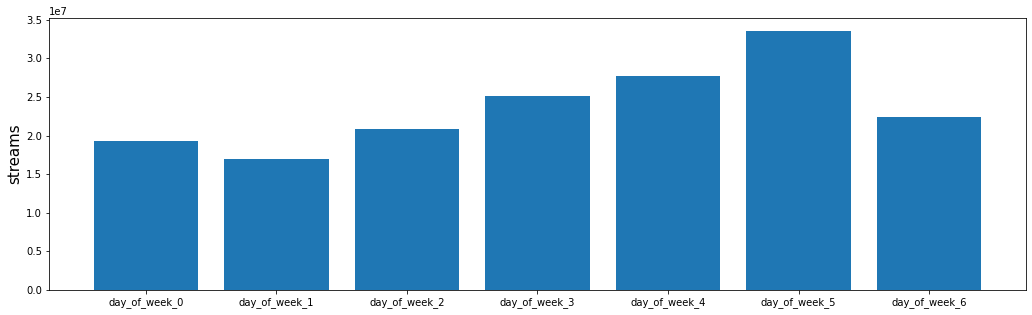

In [8]:
# # takes in a list of column names, representing one-hot encodings (like day_of_week_1, 2, etc...)
def visualize_bar_charts(encodings, target_feature="log_artist_streams"):
    encoding_average_map = {}
    for encoding in encodings:
        average_target_feature = original_df.query(f'{encoding} == "1"')[target_feature].mean()
        encoding_average_map[encoding] = average_target_feature
        
    
    labels = list(encoding_average_map.keys())
    values = list(encoding_average_map.values())
    f = plt.figure()
    f.set_figwidth(len(labels) * 2.5)
    f.set_figheight(5)
    plt.bar(range(len(labels)), values, tick_label=labels)
    plt.ylabel(target_feature, fontsize = 15)
    plt.show()

day_of_week_encodings = []
for i in range(0,7):
    day_of_week_encodings.append(f'day_of_week_{i}')

month_encodings = []
for i in range(1, 12):
    month_encodings.append(f'month_{i}')
    
visualize_bar_charts(day_of_week_encodings, "streams")
visualize_bar_charts(day_of_week_encodings, "log_artist_streams")

visualize_bar_charts(month_encodings, "streams")
visualize_bar_charts(month_encodings, "log_artist_streams")
    


In [9]:
# # takes in a list of column names, representing one-hot encodings (like day_of_week_1, 2, etc...)
def visualize_box_plots(encodings, target_feature="log_artist_streams"):
    data = []
    data_counts = {}
    for encoding in encodings:
        encoding_data = original_df.query(f'{encoding} == 1')[target_feature]
        data_counts[encoding] = len(encoding_data)
        data.append(encoding_data)
        
    fig = plt.figure(figsize =(10, 7))
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(data)
    plt.show()
    print(data_counts)

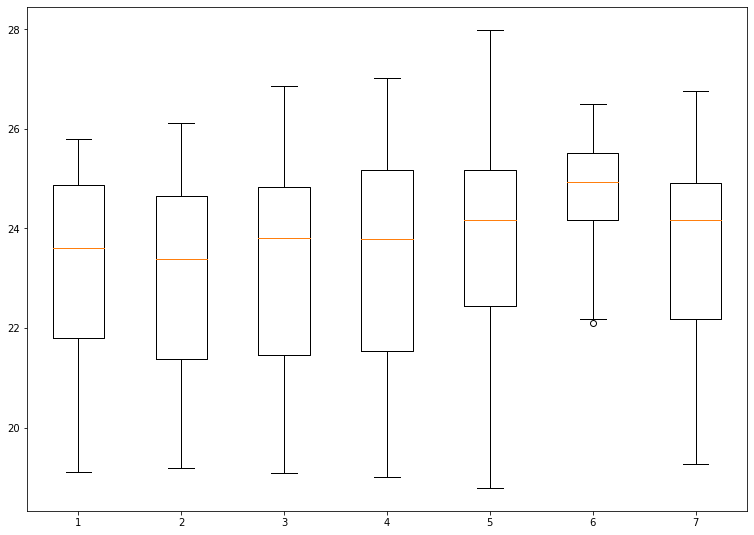

{'day_of_week_0': 42, 'day_of_week_1': 38, 'day_of_week_2': 78, 'day_of_week_3': 255, 'day_of_week_4': 1325, 'day_of_week_5': 29, 'day_of_week_6': 23}


In [10]:
# vast majority of tracks are released on friday, which has a ton of variation
# even though saturday on average is higher, it is a very small sample size.
visualize_box_plots(day_of_week_encodings, "log_artist_streams")

In [11]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm, # normalization layer
      layers.Dense(200, activation='relu'),
      layers.Dense(200, activation='relu'),
      layers.Dense(200, activation='relu'),
      layers.Dense(200, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.00008))
  return model

In [12]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [13]:
tested_models = {}

In [14]:
def test_model(model_name, target_feature, drop_features=[]):
    # drop the non target feature, so it is not used in the model building.
    dataset = None
    if target_feature == 'streams':
        dataset = top_200_df.drop(['log_artist_streams'], axis=1)
    else:
        dataset = top_200_df.drop(['streams'], axis=1)
        
    # drop other features
    dataset = dataset.drop(drop_features, axis=1)
    
    # split into train and test
    train_dataset = dataset.sample(frac=0.8, random_state=0)
    test_dataset = dataset.drop(train_dataset.index)
    
    train_features = train_dataset.copy()
    test_features = test_dataset.copy()

    train_labels = train_features.pop(target_feature)
    test_labels = test_features.pop(target_feature)
    
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(train_features).astype('float32'))
    
    dnn_model = build_and_compile_model(normalizer)
    
    train_features = train_features.astype(float)
    train_labels = train_labels.astype(float)

    test_features = test_features.astype(float)
    test_labels = test_labels.astype(float)
    
    history = dnn_model.fit(
        train_features,
        train_labels,
        validation_split=0.2,
        verbose=0, epochs=200)
    
    plot_loss(history)
    
    predicted_labels = dnn_model.predict(test_features)
    actual_labels = list(test_labels)
    coefficient_of_dermination = r2_score(actual_labels, predicted_labels)
    
    print(coefficient_of_dermination)
    
    tested_models[model_name] = dnn_model

12/12 [==============================] - 0s 1ms/step
0.13616614704632912


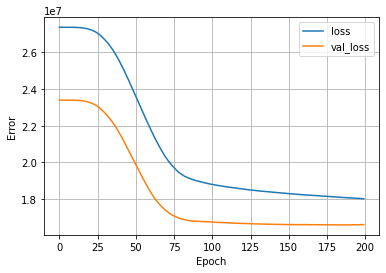

In [15]:
test_model('base_model', 'streams', drop_features=[])

12/12 [==============================] - 0s 2ms/step
0.05071126224263478


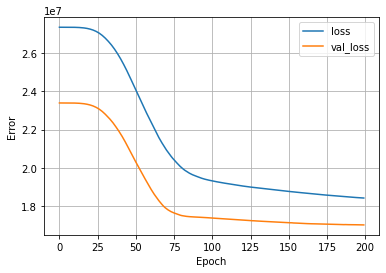

In [16]:
test_model('drop_total_follower_count', 'streams', drop_features=['total_follower_count'])

12/12 [==============================] - 0s 2ms/step
0.09940970615305378


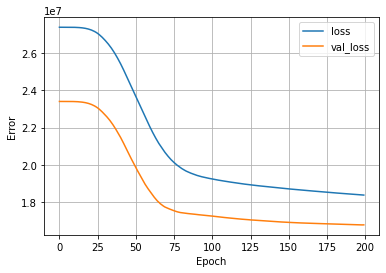

In [17]:
test_model('drop_log_total_follower_count', 'streams', drop_features=['log_total_follower_count'])

12/12 [==============================] - 0s 2ms/step
-0.08323458723163868


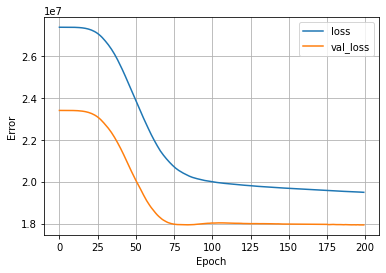

In [18]:
test_model('drop_log_total_follower_count', 'streams', drop_features=['total_follower_count','log_total_follower_count'])